In [1]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

from explore_qml_data import get_smiles
from explore_qml_data import moltosvg

In [2]:
import numpy as np
import os
import pandas as pd
import qml
import qml_interface as qmi
import analyse_atomic_data as aad

from matplotlib import pyplot as plt

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

In [3]:
def get_median_var(distribution):
    median = np.median(distribution)
    var = np.sum((distribution-median)**2)/len(distribution)
    return(median, var)

'[NH3+]CC#CC([O-])=O' is in '/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001265/atomic_energies_with_mic.txt' a strange molecule that makes trouble

In [4]:
# labels
paths = qmi.wrapper_alch_data()
paths.remove('/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_001265/atomic_energies_with_mic.txt')
data, molecule_size = qmi.load_alchemy_data(paths)

atomisation_en = qmi.generate_label_vector(data, molecule_size.sum(), value='atomisation')
atomic_en = qmi.generate_label_vector(data, molecule_size.sum(), value='atomic')
alch_pot = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')

In [5]:
median_all = np.median(atomic_en)
var_all = np.sum((atomic_en-median_all)**2)/len(atomic_en)

mean_all = np.mean(atomic_en)
var2_all = np.sum((atomic_en-mean_all)**2)/len(atomic_en)
print(median_all, var_all)
print(mean_all, var2_all)

-35.89220427042424 513.3132648131472
-25.881158255819123 413.09222250660605


In [6]:
atomic_element = aad.split_elementwise(data, molecule_size, 'atomic')

In [7]:
statistics_element = dict()
for k in atomic_element:
    med = np.median(atomic_element[k])
    var = np.sum((atomic_element[k]-med)**2)/len(atomic_element[k])
    
    mean = np.mean(atomic_element[k])
    var2 = np.sum((atomic_element[k]-mean)**2)/len(atomic_element[k])
    
    statistics_element[k] = [[med, var], [mean, var2]]

In [8]:
statistics_element

{1.0: [[-5.627911530565533, 0.07443389455868937],
  [-5.601650225465589, 0.07374423841313701]],
 6.0: [[-41.14609820464178, 7.612219640873715],
  [-40.97490083196727, 7.5829111004630585]],
 7.0: [[-50.217831059762524, 13.223975762543198],
  [-49.15152796510892, 12.086973472875341]],
 8.0: [[-58.23585343215875, 8.29445426445328],
  [-58.85887296314879, 7.906300928458222]],
 9.0: [[-75.06222975538279, 0.26040257206894174],
  [-74.86820899091641, 0.22275851502482782]]}

In [9]:
atomic_database = pd.DataFrame(index=np.arange(molecule_size.sum()), columns=['mol_id', 'smiles', 'Z', 'atomic energy', 'atomisation energy'])

In [10]:
# make a database
index_database = 0
for i, p in enumerate(paths):
    data = np.loadtxt(p)
    # get smiles
    comp = p.split('/')[-2]
    xyz_path = f'/home/misa/datasets/qm9/{comp}.xyz'
    smiles = get_smiles(xyz_path)
    for d in data:
        atomic_database.at[index_database, 'mol_id'] = i
        atomic_database.at[index_database, 'smiles'] = smiles
        atomic_database.at[index_database, 'Z'] = d[0]
        atomic_database.at[index_database, 'atomic energy'] = d[5]
        atomic_database.at[index_database, 'atomisation energy'] = d[6]
        
        index_database += 1

In [11]:
### add charge of nearest neighbours

In [12]:
nearest_neighbour = []
for i, p in enumerate(paths):
    # get smiles
    comp = p.split('/')[-2]
    xyz_path = f'/home/misa/datasets/qm9/{comp}.xyz'
    smiles = get_smiles(xyz_path)
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    nearest_neighbour.extend(aad.get_charge_neighbours(mol))
atomic_database['charge NN'] = nearest_neighbour

In [13]:
# sanity check charges from smiles should have same order as from qm9
atomic_num = []
for i, p in enumerate(paths):
    # get smiles
    comp = p.split('/')[-2]
    xyz_path = f'/home/misa/datasets/qm9/{comp}.xyz'
    smiles = get_smiles(xyz_path)
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    for atom in mol.GetAtoms():
        atomic_num.append(atom.GetAtomicNum())
atomic_database['atomic_num'] = atomic_num

In [14]:
Zs = atomic_database['Z']
atomic_nums = atomic_database['atomic_num']
counter = 0
for z, a in zip(Zs, atomic_nums):
    if z != a:
        print(counter)
    counter += 1

In [15]:
total_length = 0
for Z in set(atomic_database['Z']):
    # get charge of first coordination sphere for all atoms with same nuclear charge Z
    unique_charges = list(set(atomic_database.loc[atomic_database['Z'] == Z, 'charge NN']))
    total_length += len(unique_charges)
total_length

40

In [16]:
distributions = pd.DataFrame(index=np.arange(total_length), columns=['Z', 'charge NN', 'median', 'var', 'distribution'])

In [17]:
index_database = 0
for Z in set(atomic_database['Z']):
    # get charge of first coordination sphere for all atoms with same nuclear charge Z
    unique_charges = list(set(atomic_database.loc[atomic_database['Z'] == Z, 'charge NN']))
    unique_charges.sort()
    for u in unique_charges:
        atomic_energies_z_nn = atomic_database.loc[(atomic_database['Z'] == Z) & (atomic_database['charge NN'] == u), 'atomic energy']
        atomic_energies_z_nn = np.array(atomic_database.loc[(atomic_database['Z'] == Z) & (atomic_database['charge NN'] == u), 'atomic energy'], dtype='float64')
        med, var = get_median_var(atomic_energies_z_nn)
        distributions.at[index_database, 'Z'] = Z
        distributions.at[index_database, 'charge NN'] = u
        distributions.at[index_database, 'median'] = med
        distributions.at[index_database, 'var'] = var
        distributions.at[index_database, 'distribution'] = atomic_energies_z_nn
        index_database += 1

### Plot results

In [18]:
N_tot = len(atomic_en)
N_tot

13108

In [19]:
variance_el = 0
for k in statistics_element.keys():
    var_normalized = statistics_element[k][0][1] * len(atomic_element[k])/N_tot
    variance_el += var_normalized

In [20]:
variance_el

4.509623646990174

In [21]:
tick_label = ['all', 'H', 'C', 'N', 'O', 'F']

variance = [var_all]
x_bar = [0]

for k in statistics_element.keys():
    variance.append(statistics_element[k][0][1])
xbar_tmp = np.arange(len(statistics_element))+2
x_bar.extend(xbar_tmp)

In [22]:
var_cs1 = 0
for s in set(distributions['Z']):
    cNN = distributions.loc[distributions['Z'] == s, 'charge NN']
    for c in cNN:
        #print(s, c)
        N_I = len(distributions.loc[(distributions['Z'] == s) & (distributions['charge NN'] == c), 'distribution'].item())
        var = distributions.loc[(distributions['Z'] == int(s)) & (distributions['charge NN'] == c), 'var'].item()
        var_cs1 += var*N_I
var_cs1 = var_cs1/N_tot

In [23]:
var_cs1

0.6610912511867718

Text(0, 0.5, '$\\sigma^2$')

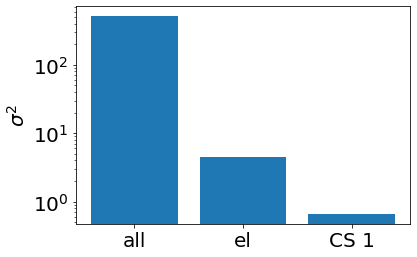

In [24]:
plt.rcParams['font.size'] = 20
plt.bar([1,2,3], [var_all, variance_el, var_cs1], tick_label=['all', 'el', 'CS 1'])
plt.yscale('log')
plt.ylabel(r'$\sigma^2$')

In [25]:
H_CS1 = np.array(distributions.loc[distributions['Z'] == 1, ['charge NN', 'var']])
C_CS1 = np.array(distributions.loc[distributions['Z'] == 6, ['charge NN', 'var']])
N_CS1 = np.array(distributions.loc[distributions['Z'] == 7, ['charge NN', 'var']])
O_CS1 = np.array(distributions.loc[distributions['Z'] == 8, ['charge NN', 'var']])

In [26]:
distributions.loc[distributions['Z'] == 1, 'charge NN']

0    6
1    7
2    8
Name: charge NN, dtype: object

### Distributions for H

In [27]:
dH = distributions.loc[distributions['Z'] == 1]

In [28]:
#fig, ax = plt.subplots(1,1)
energies_H = []
cnn_H = []
for cN in dH['charge NN']:
    energy = dH.loc[dH['charge NN'] == cN, 'distribution'].item()
    energies_H.extend(energy)
    cnn_H.extend(np.full_like(energy, cN))
    #ax.scatter(np.full_like(energy, cN), energy)

/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


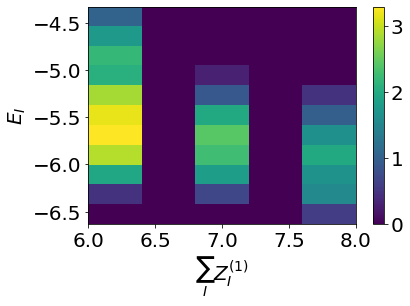

In [29]:
#H, xedges, yedges = np.histogram2d(x, y, bins=[gridx, gridy])
H, xedges, yedges  = np.histogram2d(cnn_H, energies_H, bins=[5, 5*(np.amax(energies_H)-np.amin(energies_H))])
H_scaled = np.log10(H)
H_scaled[np.isneginf(H_scaled)]=0
plt.rcParams['font.size'] = 20
plt.figure()
myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.imshow(H_scaled.T,origin='low',extent=myextent,interpolation='none',aspect='auto')
#plt.imshow(H_scaled.T,origin='low',extent=myextent,interpolation='bilinear',aspect='auto')

plt.colorbar()
plt.xlabel(r'$\sum_I Z_I^{(1)}$')

plt.ylabel(r'$E_I$')
#plt.ylabel(r'$|E_I^{\rm at} - E_J^{\rm at}|$')

plt.show()

### Distributions for C

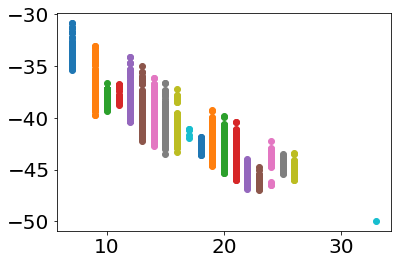

In [30]:
dC = distributions.loc[distributions['Z'] == 6]
fig, ax = plt.subplots(1,1)
for cN in dC['charge NN']:
    energy = dC.loc[dC['charge NN'] == cN, 'distribution'].item()
    ax.scatter(np.full_like(energy, cN), energy)

In [31]:
dC = distributions.loc[distributions['Z'] == 6]
energies_C = []
cnn_C = []
for cN in dC['charge NN']:
    energy = dC.loc[dC['charge NN'] == cN, 'distribution'].item()
    energies_C.extend(energy)
    cnn_C.extend(np.full_like(energy, cN))


/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


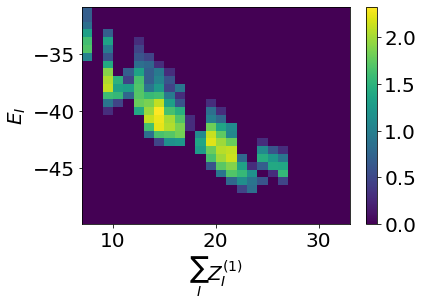

In [32]:
#H, xedges, yedges = np.histogram2d(x, y, bins=[gridx, gridy])
C, xedges, yedges  = np.histogram2d(cnn_C, energies_C, bins=[np.amax(cnn_C)-np.amin(cnn_C), 1.5*(np.amax(energies_C)-np.amin(energies_C))])
C_scaled = np.log10(C)
C_scaled[np.isneginf(C_scaled)]=0
plt.rcParams['font.size'] = 20
plt.figure()
myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.imshow(C_scaled.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto')
#plt.imshow(H_scaled.T,origin='low',extent=myextent,interpolation='bilinear',aspect='auto')

plt.colorbar()
plt.xlabel(r'$\sum_I Z_I^{(1)}$')

plt.ylabel(r'$E_I$')
#plt.ylabel(r'$|E_I^{\rm at} - E_J^{\rm at}|$')

plt.show()

In [71]:
for i, s in enumerate(smi):
    if i == 13:
        print(s)

CC12CC3OC1C23


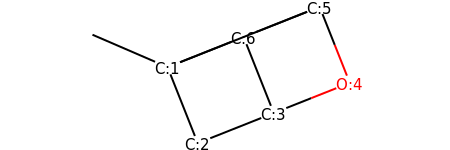

In [75]:
mol = Chem.MolFromSmiles('CC12CC3OC1C23')
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(mol)

In [76]:
#atomic_database.loc[(atomic_database['Z']==6) & (atomic_database['smiles']=='CC12CC3OC1C23')]
atomic_database.loc[(atomic_database['smiles']=='CC12CC3OC1C23')]

,mol_id,smiles,Z,atomic energy,atomisation energy,charge NN,atomic_num
3046,221,CC12CC3OC1C23,6,-37.6636,3.55102,9,6
3047,221,CC12CC3OC1C23,6,-44.3531,-3.13851,24,6
3048,221,CC12CC3OC1C23,6,-41.487,-0.272373,14,6
3049,221,CC12CC3OC1C23,6,-43.1591,-1.94445,21,6
3050,221,CC12CC3OC1C23,8,-61.0098,17.4226,12,8
3051,221,CC12CC3OC1C23,6,-43.6974,-2.48277,21,6
3052,221,CC12CC3OC1C23,6,-42.6288,-1.41421,19,6
3053,221,CC12CC3OC1C23,1,-5.39058,-1.52246,6,1
3054,221,CC12CC3OC1C23,1,-5.38418,-1.51606,6,1
3055,221,CC12CC3OC1C23,1,-5.45468,-1.58655,6,1


48


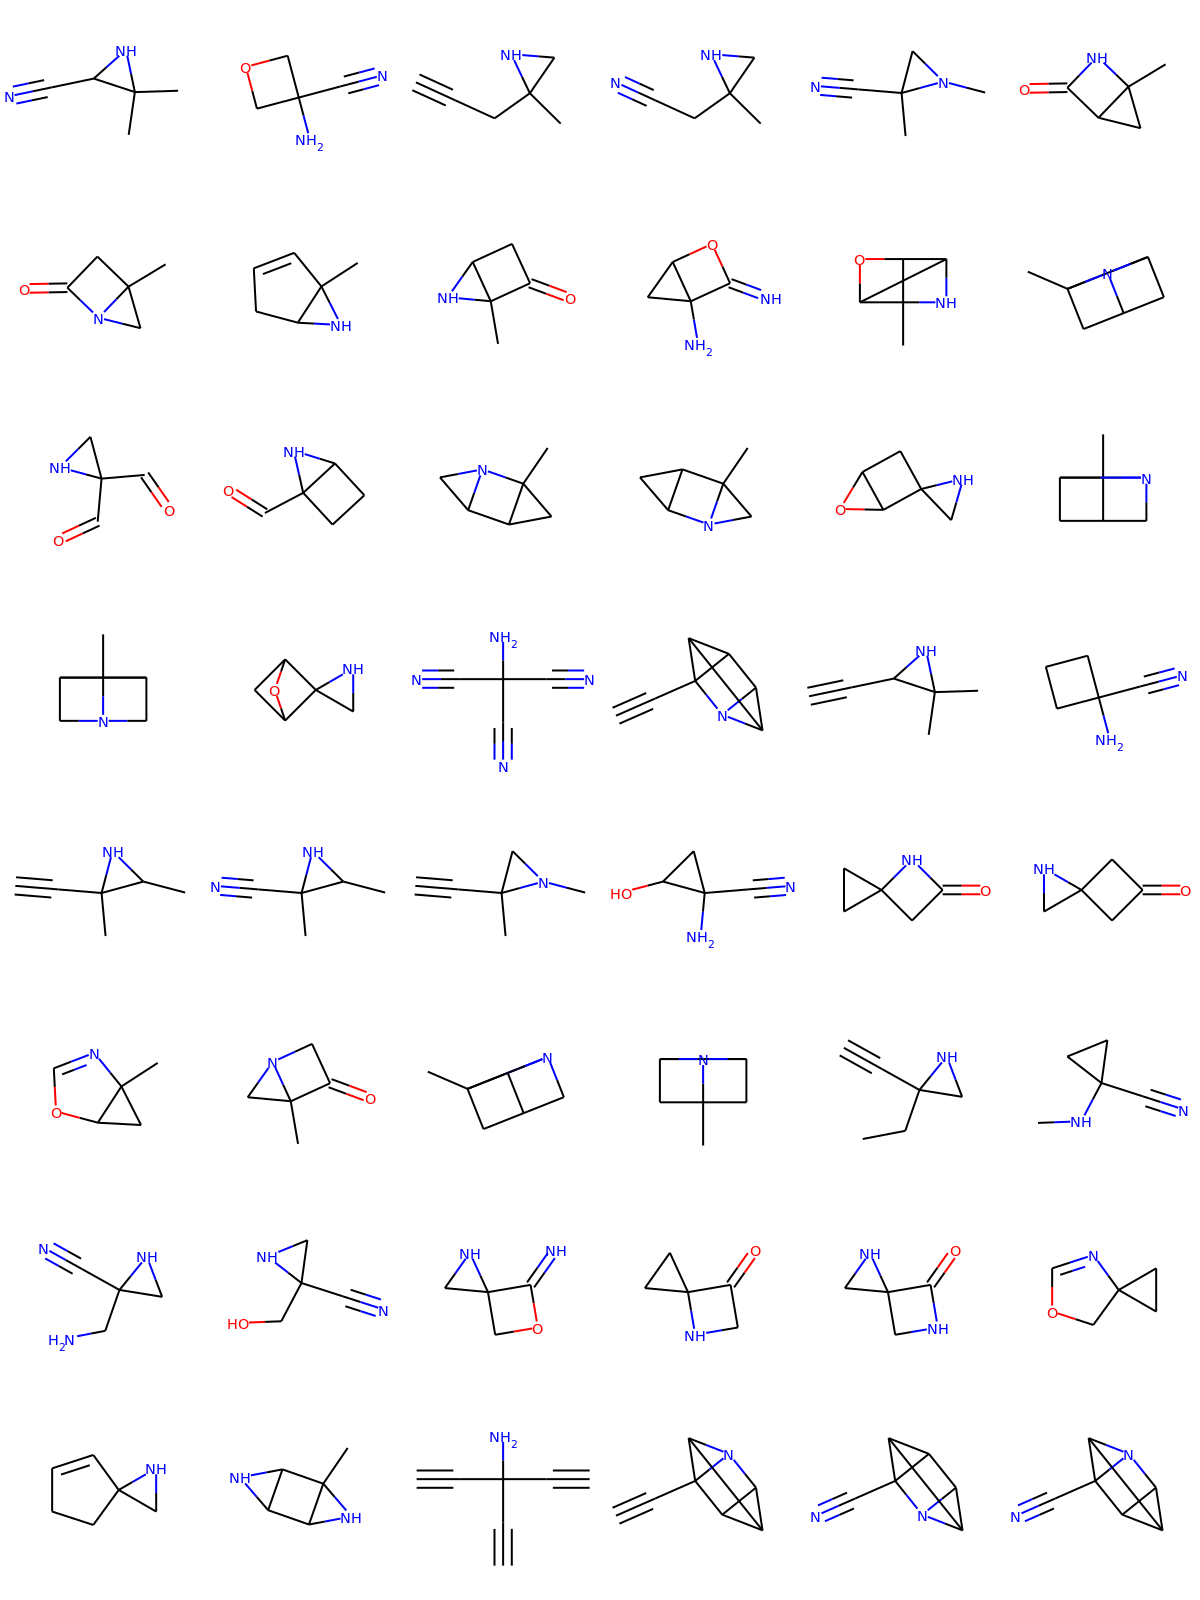

In [77]:
smi = atomic_database.loc[(atomic_database['Z']==6) & (atomic_database['charge NN']==25), 'smiles']
mols = []
for s in smi:
    mols.append(Chem.MolFromSmiles(s))
print(len(smi), flush=True)
Chem.Draw.MolsToGridImage(mols,molsPerRow=6,subImgSize=(200,200))

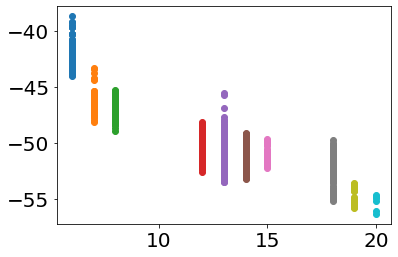

In [33]:
dN = distributions.loc[distributions['Z'] == 7]
fig, ax = plt.subplots(1,1)
for cN in dN['charge NN']:
    energy = dN.loc[dN['charge NN'] == cN, 'distribution'].item()
    ax.scatter(np.full_like(energy, cN), energy)

/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


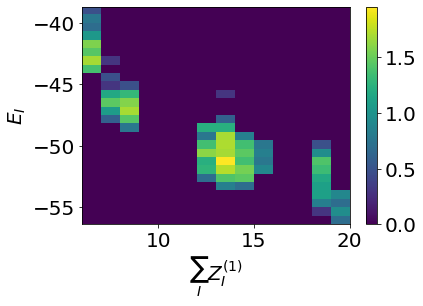

In [41]:
energies_N = []
cnn_N = []
for cN in dN['charge NN']:
    energy = dN.loc[dN['charge NN'] == cN, 'distribution'].item()
    energies_N.extend(energy)
    cnn_N.extend(np.full_like(energy, cN))

N, xedges, yedges  = np.histogram2d(cnn_N, energies_N, bins=[np.amax(cnn_N)-np.amin(cnn_N), 1.5*(np.amax(energies_N)-np.amin(energies_N))])
N_scaled = np.log10(N)
N_scaled[np.isneginf(N_scaled)]=0
plt.rcParams['font.size'] = 20
plt.figure()
myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.imshow(N_scaled.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto')
#plt.imshow(H_scaled.T,origin='low',extent=myextent,interpolation='bilinear',aspect='auto')

plt.colorbar()
plt.xlabel(r'$\sum_I Z_I^{(1)}$')

plt.ylabel(r'$E_I$')
#plt.ylabel(r'$|E_I^{\rm at} - E_J^{\rm at}|$')

plt.show()

In [42]:
xedges

array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20.])

In [47]:
atomic_database.loc[(atomic_database['Z']==7) & (atomic_database['atomic energy']==-45.51923787985615)]

,mol_id,smiles,Z,atomic energy,atomisation energy,charge NN,atomic_num
10999,802,CCC#CC1CN1,7,-45.5192,10.9878,13,7


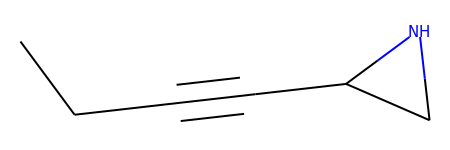

In [49]:
Chem.MolFromSmiles('CCC#CC1CN1')

In [61]:
atomic_database.loc[(atomic_database['Z']==7) & (atomic_database['smiles']=='CC1(CC#C)CN1')]

,mol_id,smiles,Z,atomic energy,atomisation energy,charge NN,atomic_num
1959,143,CC1(CC#C)CN1,7,-48.7673,8.65347,13,7


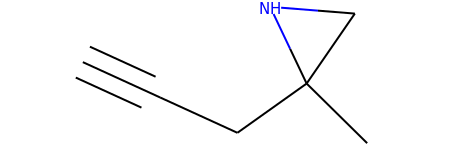

In [60]:
Chem.MolFromSmiles('CC1(CC#C)CN1')

In [59]:
for i, s in enumerate(smi):
    if i == 49:
        print(s)

CC1(CC#C)CN1


22


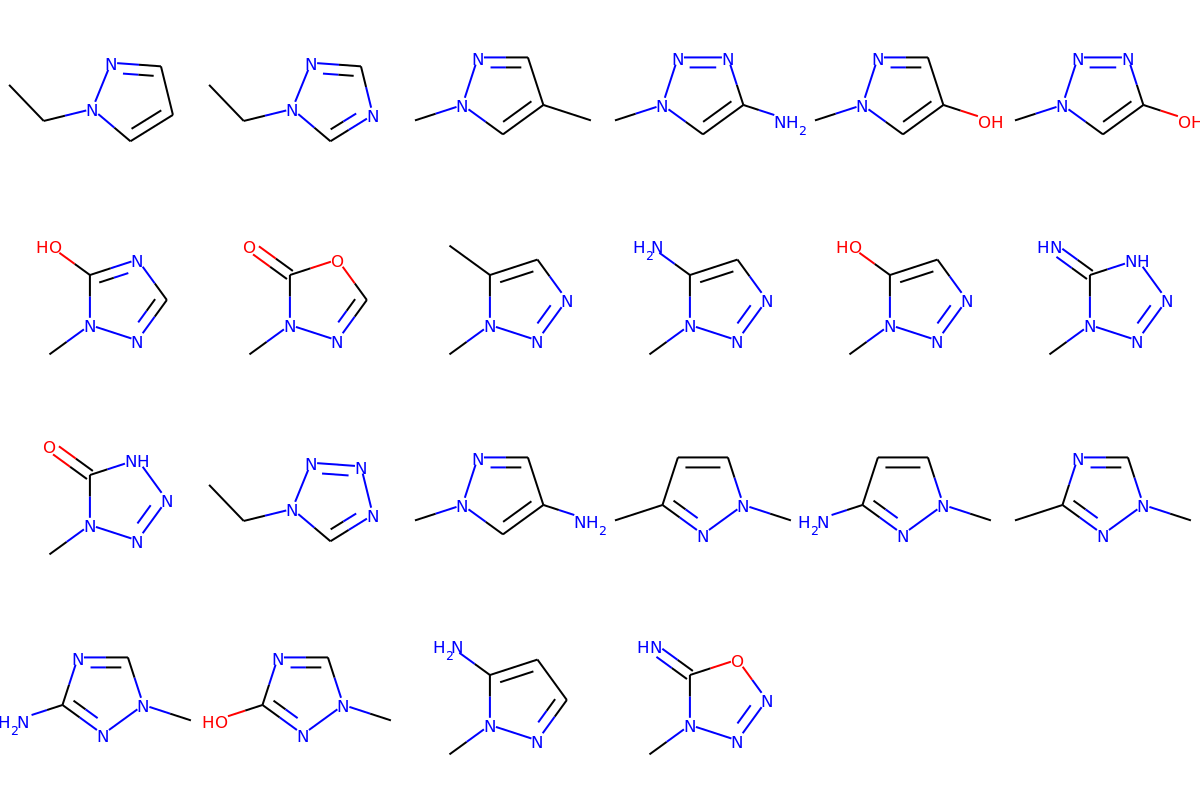

In [63]:
smi = atomic_database.loc[(atomic_database['Z']==7) & (atomic_database['charge NN']==19), 'smiles']
mols = []
for s in smi:
    mols.append(Chem.MolFromSmiles(s))
print(len(smi), flush=True)
Chem.Draw.MolsToGridImage(mols,molsPerRow=6,subImgSize=(200,200))
#Chem.Draw.MolsToGridImage(mols[30:],molsPerRow=6,subImgSize=(200,200))

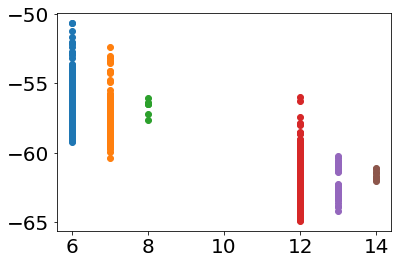

In [37]:
dO = distributions.loc[distributions['Z'] == 8]
fig, ax = plt.subplots(1,1)
for cN in dO['charge NN']:
    energy = dO.loc[dO['charge NN'] == cN, 'distribution'].item()
    ax.scatter(np.full_like(energy, cN), energy)

/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


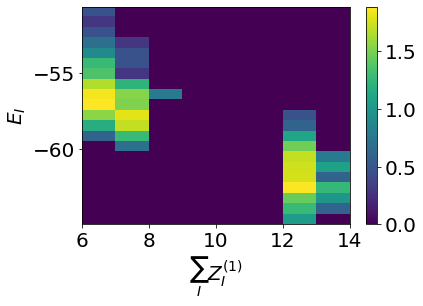

In [38]:
energies_O = []
cnn_O = []
for cN in dO['charge NN']:
    energy = dO.loc[dO['charge NN'] == cN, 'distribution'].item()
    energies_O.extend(energy)
    cnn_O.extend(np.full_like(energy, cN))

O, xedges, yedges  = np.histogram2d(cnn_O, energies_O, bins=[np.amax(cnn_O)-np.amin(cnn_O), 1.5*(np.amax(energies_O)-np.amin(energies_O))])
O_scaled = np.log10(O)
O_scaled[np.isneginf(O_scaled)]=0
plt.rcParams['font.size'] = 20
plt.figure()
myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.imshow(O_scaled.T,origin='low',extent=myextent,interpolation='none',aspect='auto')
#plt.imshow(H_scaled.T,origin='low',extent=myextent,interpolation='bilinear',aspect='auto')

plt.colorbar()
plt.xlabel(r'$\sum_I Z_I^{(1)}$')

plt.ylabel(r'$E_I$')
#plt.ylabel(r'$|E_I^{\rm at} - E_J^{\rm at}|$')

plt.show()

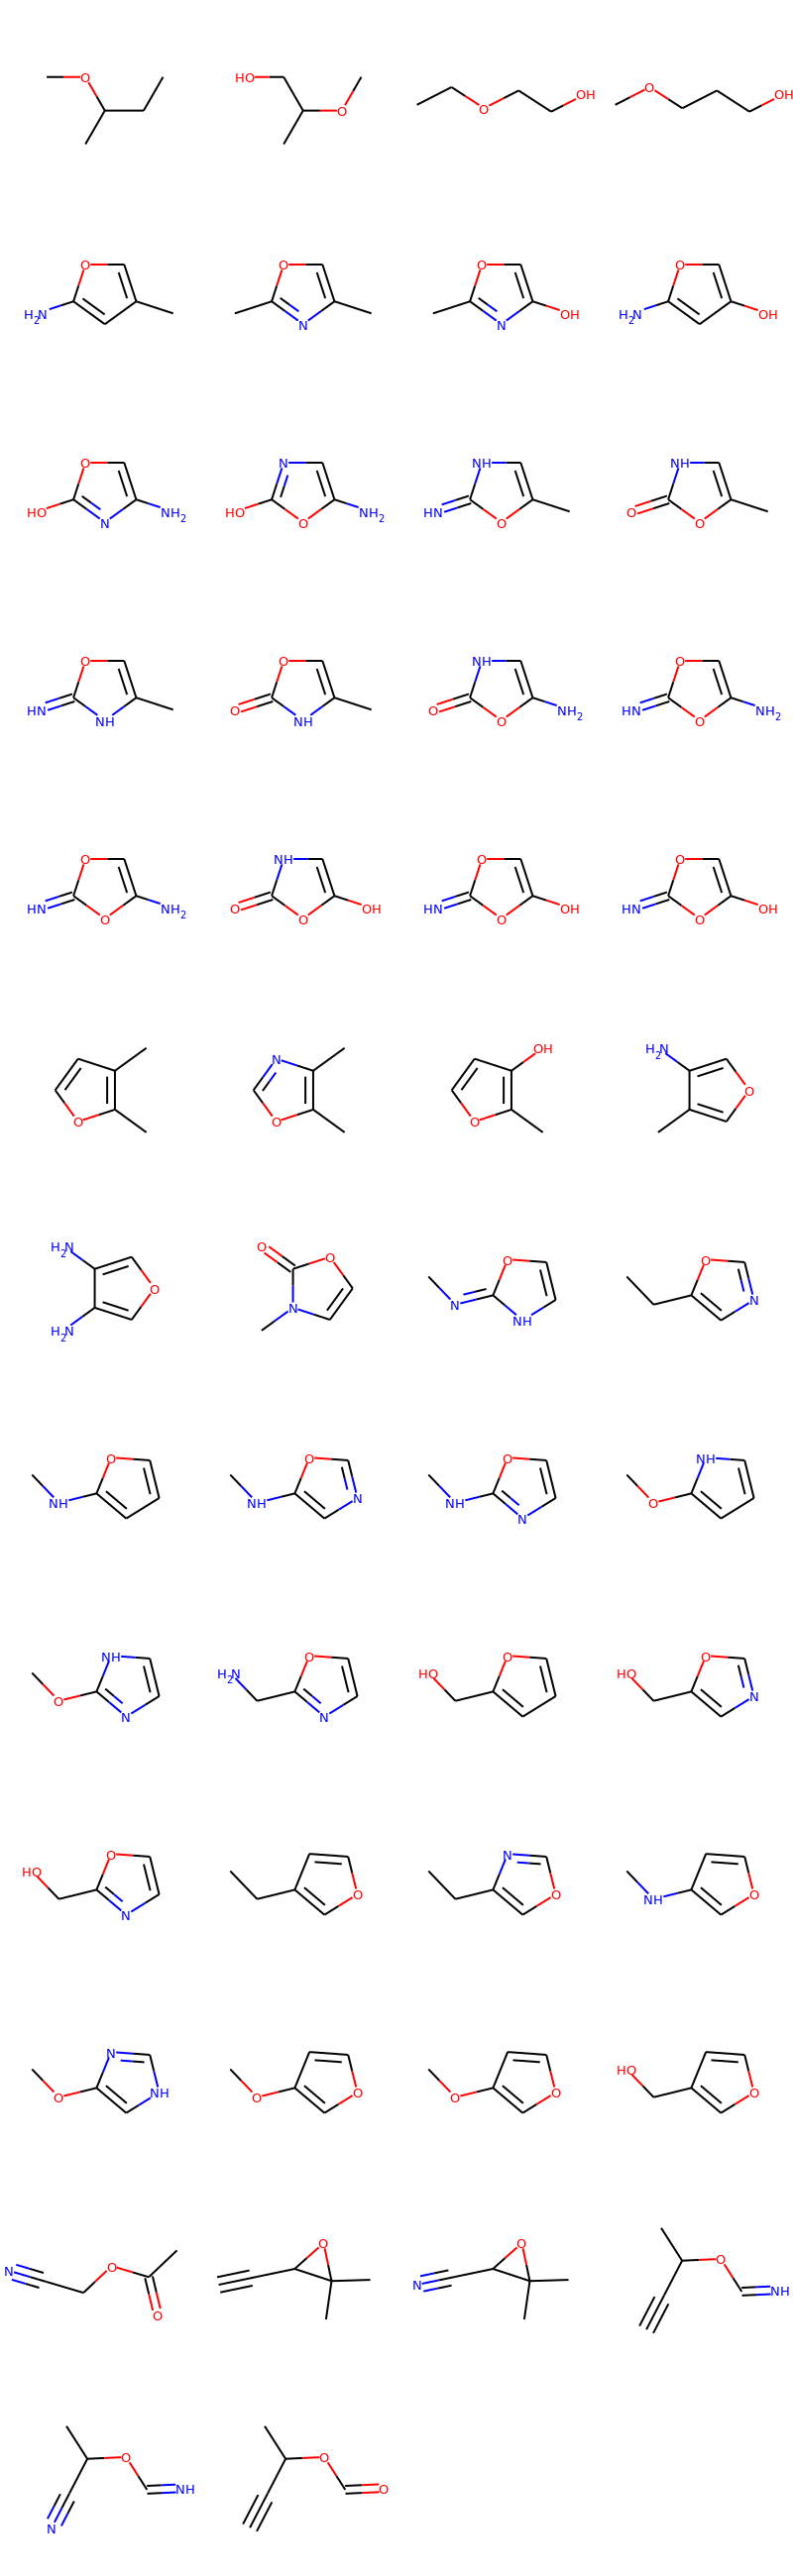

In [39]:
smi = atomic_database.loc[(atomic_database['Z']==8) & (atomic_database['charge NN']==12), 'smiles']
mols = []
for s in smi:
    mols.append(Chem.MolFromSmiles(s))
    
Chem.Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200))

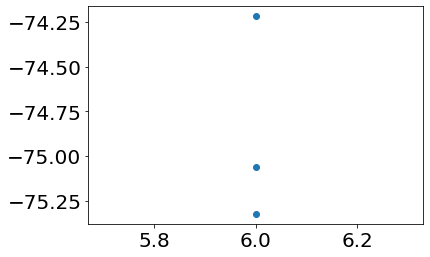

In [40]:
dF = distributions.loc[distributions['Z'] == 9]
fig, ax = plt.subplots(1,1)
for cN in dF['charge NN']:
    energy = dF.loc[dF['charge NN'] == cN, 'distribution'].item()
    ax.scatter(np.full_like(energy, cN), energy)